In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pylab import rcParams

from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM
from neuralforecast.auto import AutoLSTM

from src.data.loaders import CommodityLoader
from src.utils.split_series import split_series
from src.evaluation.evaluation import MetricEvaluator

In [2]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#212946',
    'axes.facecolor': '#212946',
    'savefig.facecolor':'#212946',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#2A3459',
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12 
}
plt.rcParams.update(dark_style)

In [3]:
df_brl = CommodityLoader.load_all_commodities(currency='BRL', preprocessing=True, monthly_aggregation='mean', limit_date=None)

ദ്ദി・ᴗ・)✧ acucar_santos carregado com sucesso
ദ്ദി・ᴗ・)✧ acucar_sp carregado com sucesso
ദ്ദി・ᴗ・)✧ algodao carregado com sucesso
ദ്ദി・ᴗ・)✧ arroz carregado com sucesso
ദ്ദി・ᴗ・)✧ cafe_arabica carregado com sucesso
ദ്ദി・ᴗ・)✧ cafe_robusta carregado com sucesso
ദ്ദി・ᴗ・)✧ milho carregado com sucesso
ദ്ദി・ᴗ・)✧ soja_parana carregado com sucesso
ദ്ദി・ᴗ・)✧ soja_paranagua carregado com sucesso
ദ്ദി・ᴗ・)✧ trigo_parana carregado com sucesso
ദ്ദി・ᴗ・)✧ trigo_rs carregado com sucesso


In [4]:
train, val, test = split_series(df_brl)

Treino + Val ACUCAR_SANTOS: 45 | Teste ACUCAR_SANTOS: 20
Treino + Val ACUCAR_SP: 185 | Teste ACUCAR_SP: 80
Treino + Val ALGODAO: 243 | Teste ALGODAO: 105
Treino + Val ARROZ: 168 | Teste ARROZ: 72
Treino + Val CAFE_ARABICA: 241 | Teste CAFE_ARABICA: 104
Treino + Val CAFE_ROBUSTA: 201 | Teste CAFE_ROBUSTA: 87
Treino + Val MILHO: 175 | Teste MILHO: 75
Treino + Val SOJA_PARANA: 234 | Teste SOJA_PARANA: 101
Treino + Val SOJA_PARANAGUA: 161 | Teste SOJA_PARANAGUA: 70
Treino + Val TRIGO_PARANA: 179 | Teste TRIGO_PARANA: 77
Treino + Val TRIGO_RS: 179 | Teste TRIGO_RS: 77
Splitted data into TRAIN with size 1605, VALIDATION with size 406 and TEST with size 868


In [5]:
model = LSTM(
    h=1, # Horizonte de previsão, conforme definido no AutoLSTM
    input_size=12, # Tamanho da sequência de entrada (número de lags/passos históricos)
                   # Geralmente, um múltiplo da sazonalidade ou um valor razoável.
                   # Pode ser ajustado com base na frequência dos dados e na complexidade do padrão.
    encoder_n_layers=2, # Número de camadas do encoder LSTM
    encoder_hidden_size=64, # Número de unidades ocultas em cada camada do encoder LSTM
    decoder_layers=2, # Número de camadas do decoder MLP
    decoder_hidden_size=32, # Número de unidades ocultas em cada camada do decoder MLP
    max_steps=500, # Número máximo de passos de treinamento (epochs)
    learning_rate=0.001, # Taxa de aprendizado
    batch_size=32, # Tamanho do batch para treinamento
)

fcst = NeuralForecast(
    models=[model],
    freq='M'
)

Seed set to 1


In [6]:
full_train = pd.concat([train, val])

In [7]:
def plot_single_series_and_forecasts(df_brl, forecasts_df, test_size):
    """
    Plota a série completa e as previsões para a única série presente no df
    """
    uid = df_brl['unique_id'].unique()[0]  # pega o único valor existente
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 8))

    series_data = df_brl.copy()
    train_data = df_brl.iloc[:-test_size].copy()
    test_data = df_brl.iloc[-test_size:].copy()
    true_forecast = forecasts_df[forecasts_df['unique_id'] == uid].copy()

    # Série completa
    ax.plot(series_data['ds'], series_data['y'], 
            color='lime', linewidth=1.5, label='Série Completa')

    # Treino
    ax.plot(train_data['ds'], train_data['y'], 
            color='cyan', linewidth=2, label='Treino')

    # Teste real
    ax.plot(test_data['ds'], test_data['y'], 
            color='fuchsia', linewidth=2, label='Teste (Real)')

    # Previsões
    ax.plot(true_forecast['ds'], true_forecast['LSTM'], 
            color='red', linewidth=2, linestyle='--', label='Previsão LSTM')

    # Linha vertical início teste
    if len(test_data) > 0:
        ax.axvline(x=test_data['ds'].iloc[0], color='orange', 
                  linestyle=':', alpha=0.8, linewidth=2, label='Início Teste')

    # Configurações do gráfico
    ax.set_title(f'Série Temporal e Previsões - {uid}', 
                fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Data', fontsize=12)
    ax.set_ylabel('Preço', fontsize=12)
    ax.legend(fontsize=10, loc='best')
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    print(f"Gráfico exibido para: {uid}")
    print("-" * 50)


=== Rodando Cross Validation para ACUCAR_SANTOS (Teste=20) ===


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 50.4 K | train
4 | mlp_decoder  | MLP           | 2.1 K  | train
-------------------------------------------------------
52.5 K    Trainable params
0         Non-trainable params
52.5 K    Total params
0.210     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

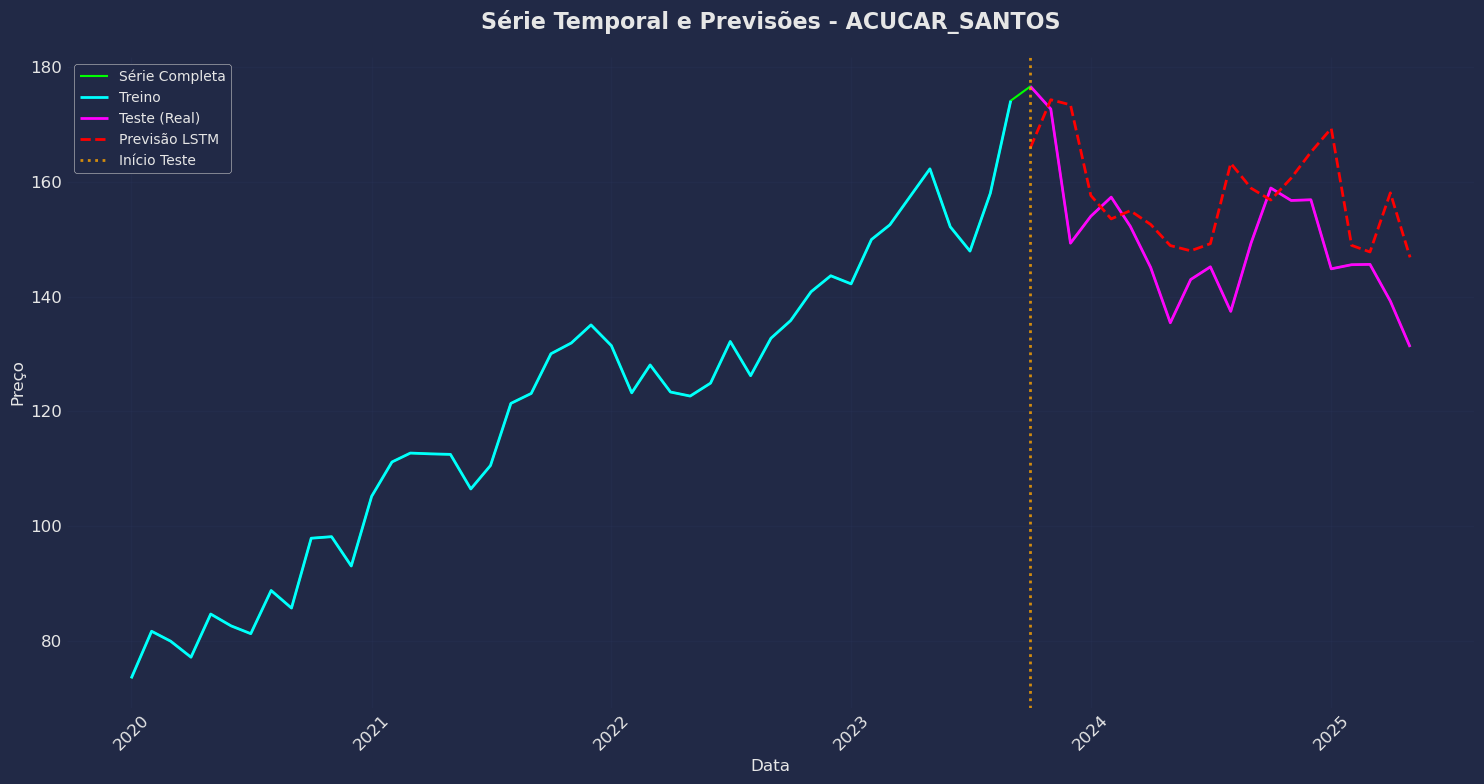

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Gráfico exibido para: ACUCAR_SANTOS
--------------------------------------------------

=== Rodando Cross Validation para ACUCAR_SP (Teste=80) ===



  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 50.4 K | train
4 | mlp_decoder  | MLP           | 2.1 K  | train
-------------------------------------------------------
52.5 K    Trainable params
0         Non-trainable params
52.5 K    Total params
0.210     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

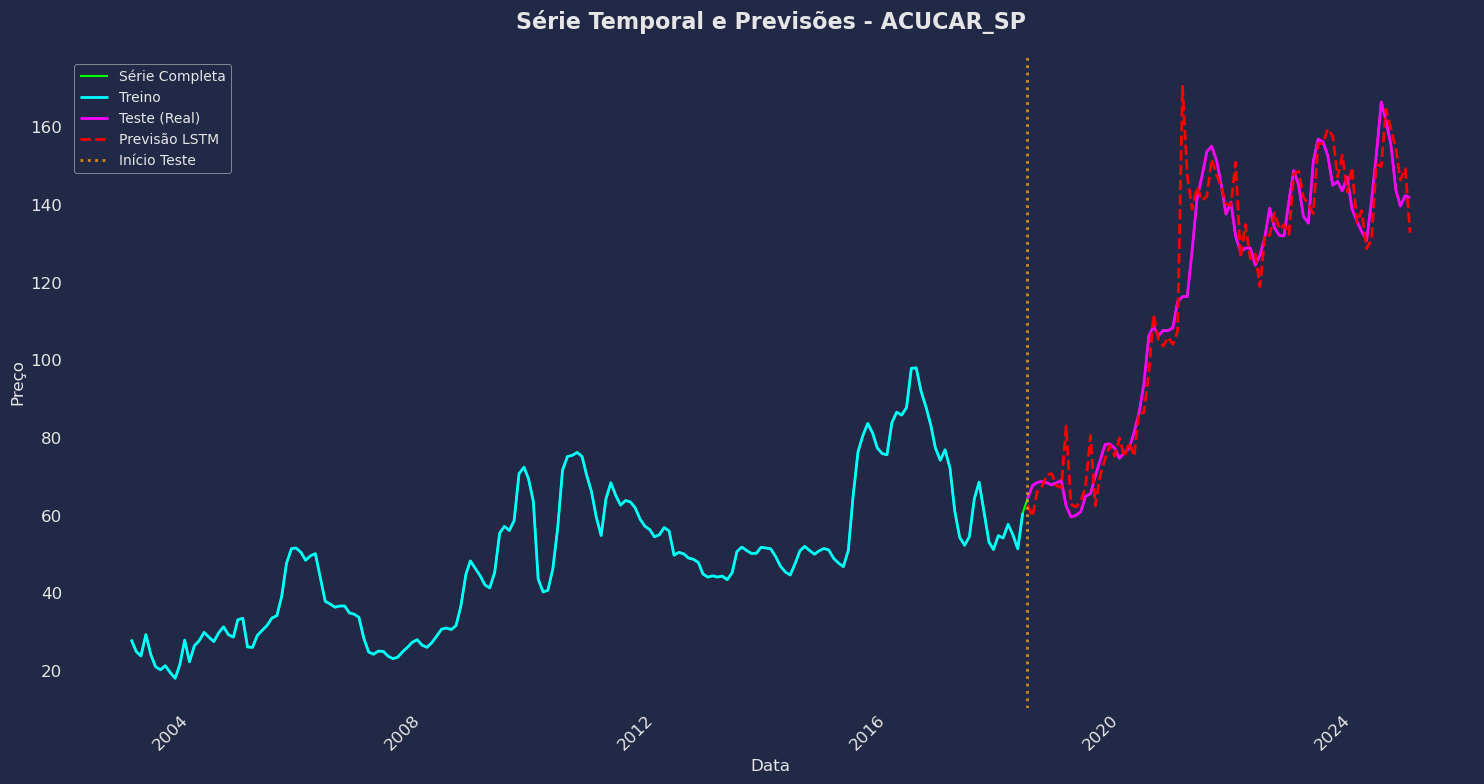

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Gráfico exibido para: ACUCAR_SP
--------------------------------------------------

=== Rodando Cross Validation para ALGODAO (Teste=105) ===



  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 50.4 K | train
4 | mlp_decoder  | MLP           | 2.1 K  | train
-------------------------------------------------------
52.5 K    Trainable params
0         Non-trainable params
52.5 K    Total params
0.210     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

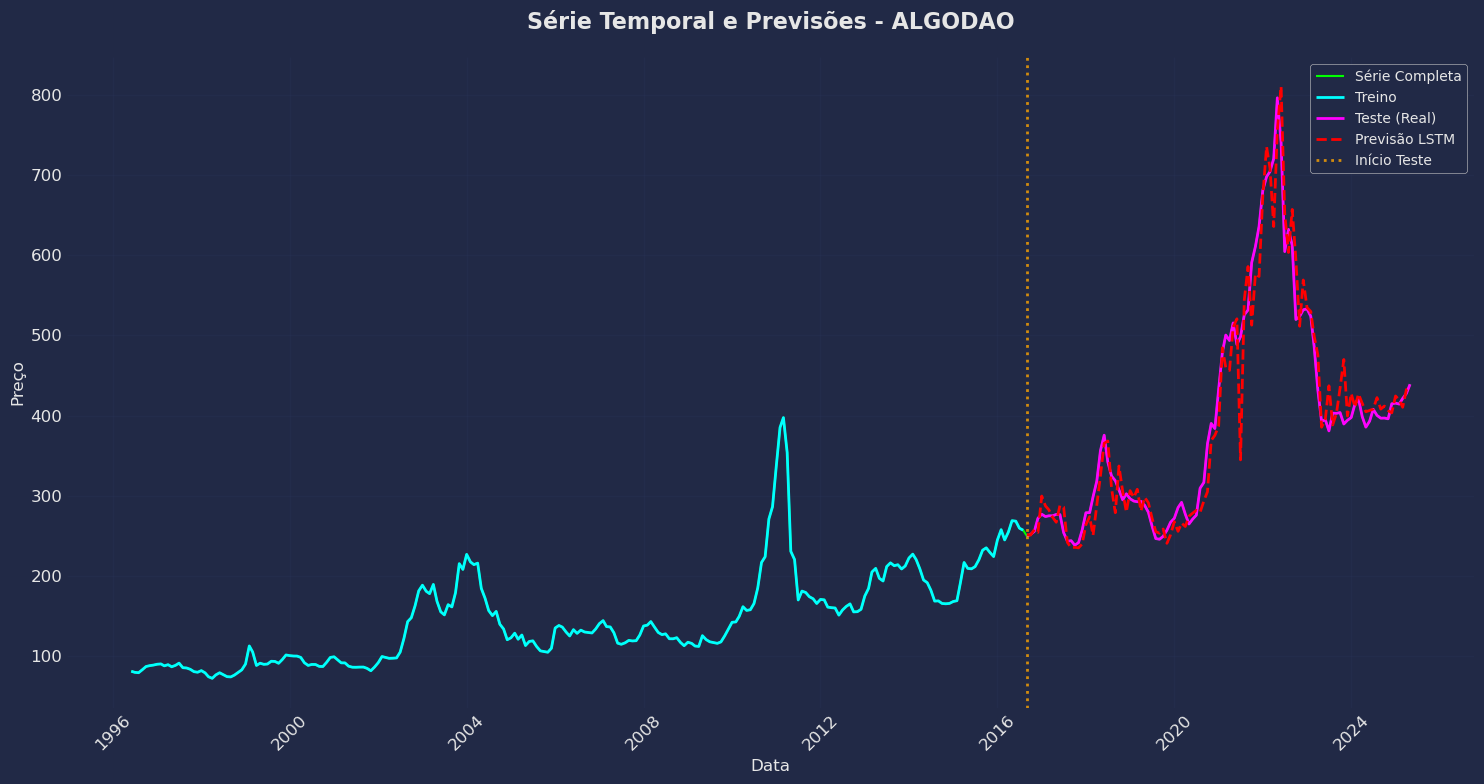

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Gráfico exibido para: ALGODAO
--------------------------------------------------

=== Rodando Cross Validation para ARROZ (Teste=72) ===



  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 50.4 K | train
4 | mlp_decoder  | MLP           | 2.1 K  | train
-------------------------------------------------------
52.5 K    Trainable params
0         Non-trainable params
52.5 K    Total params
0.210     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

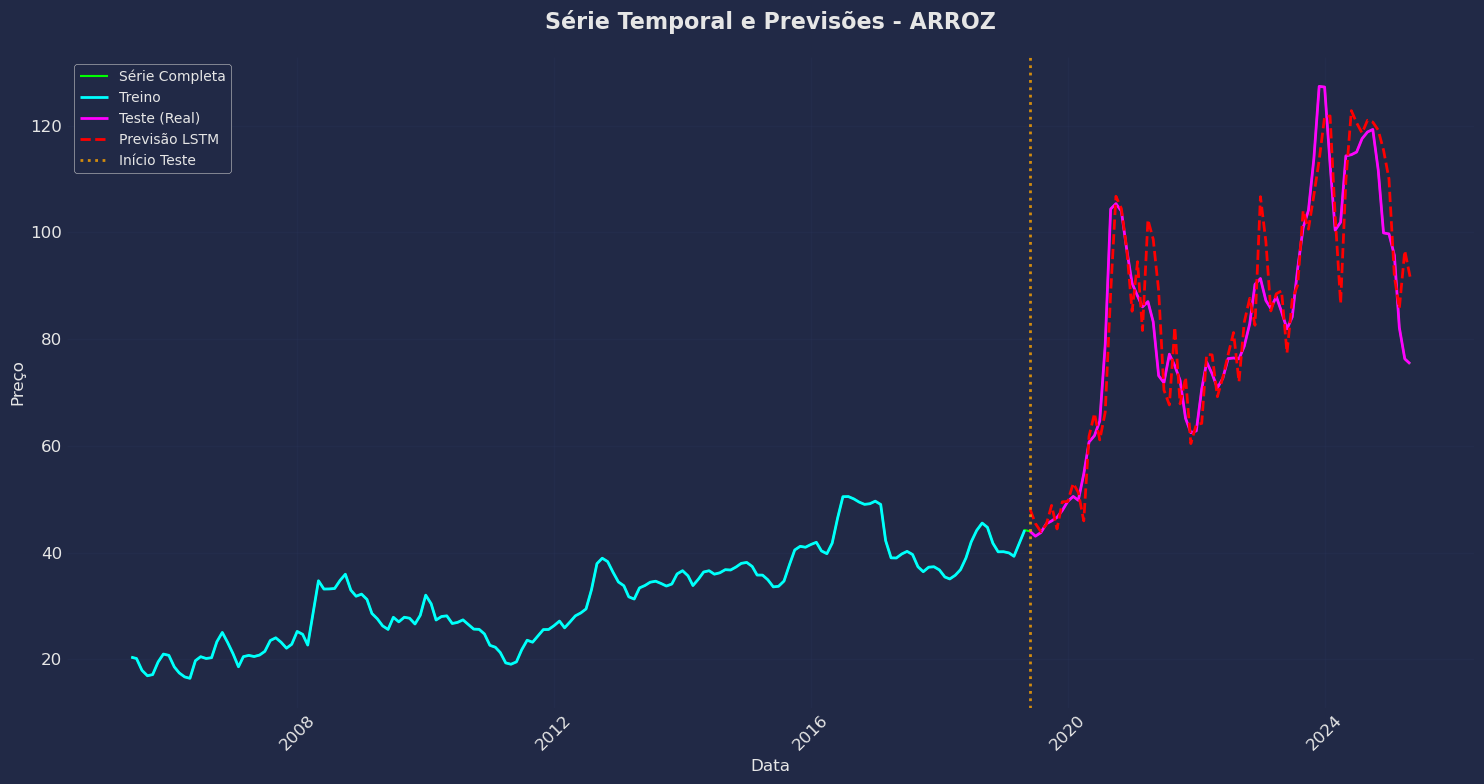

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Gráfico exibido para: ARROZ
--------------------------------------------------

=== Rodando Cross Validation para CAFE_ARABICA (Teste=104) ===



  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 50.4 K | train
4 | mlp_decoder  | MLP           | 2.1 K  | train
-------------------------------------------------------
52.5 K    Trainable params
0         Non-trainable params
52.5 K    Total params
0.210     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

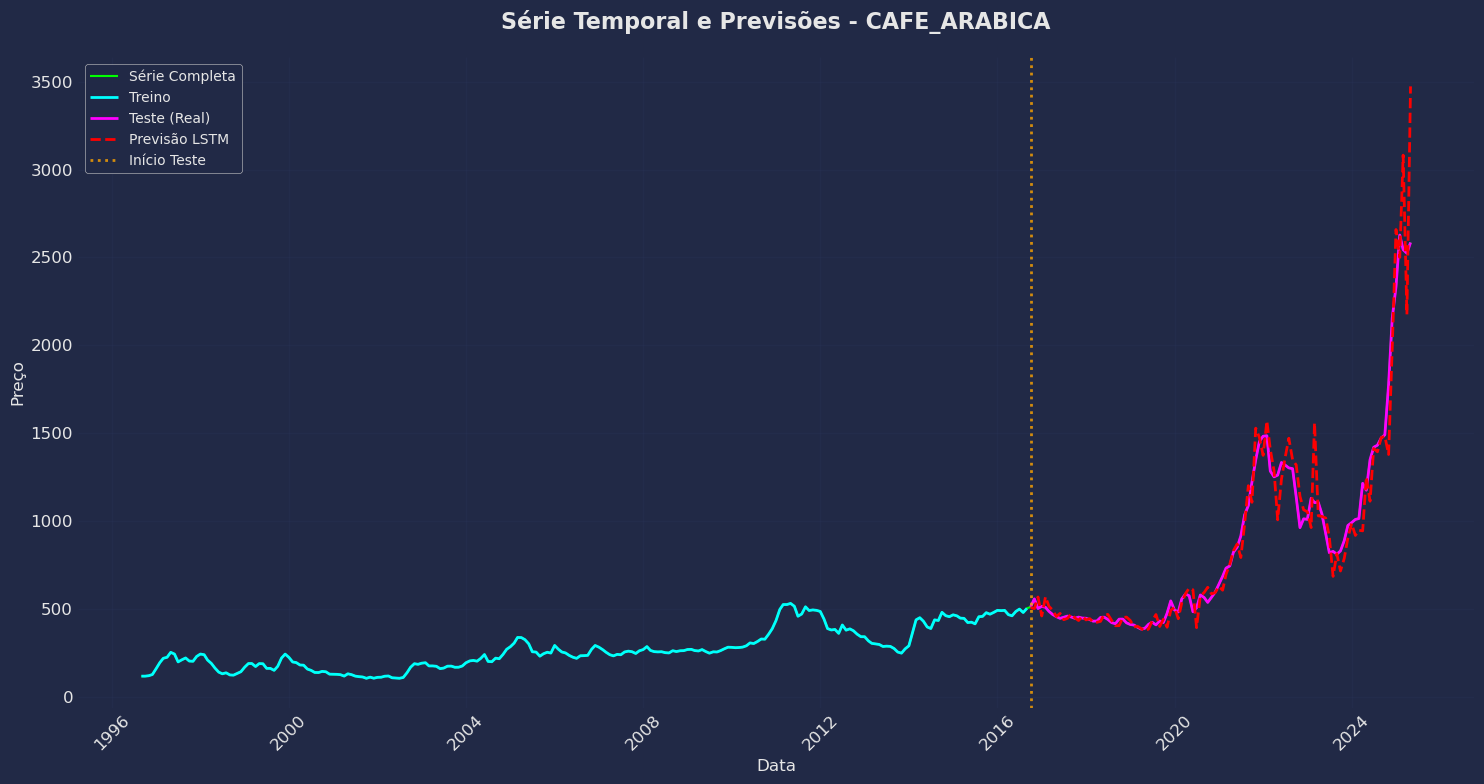

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Gráfico exibido para: CAFE_ARABICA
--------------------------------------------------

=== Rodando Cross Validation para CAFE_ROBUSTA (Teste=87) ===



  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 50.4 K | train
4 | mlp_decoder  | MLP           | 2.1 K  | train
-------------------------------------------------------
52.5 K    Trainable params
0         Non-trainable params
52.5 K    Total params
0.210     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

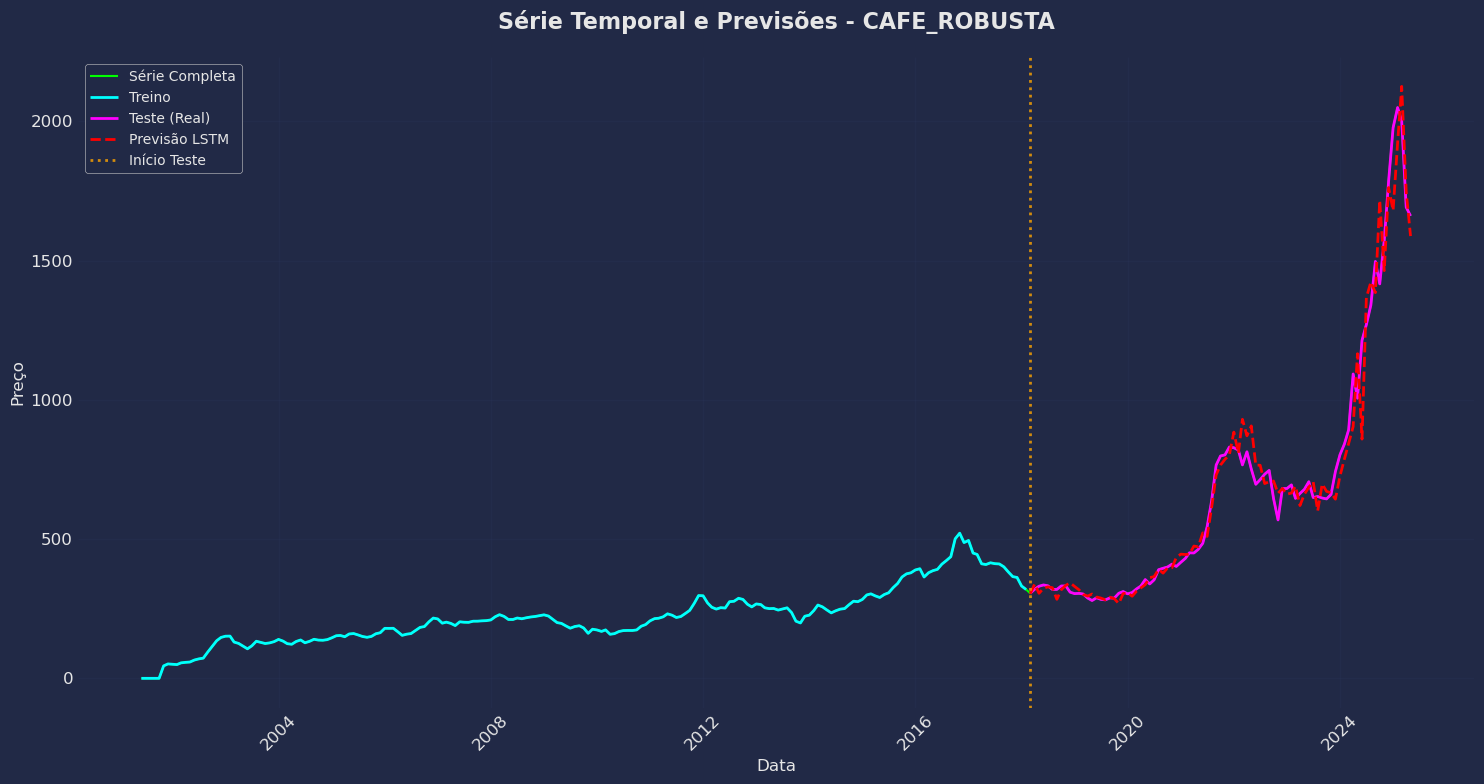

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Gráfico exibido para: CAFE_ROBUSTA
--------------------------------------------------

=== Rodando Cross Validation para MILHO (Teste=75) ===



  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 50.4 K | train
4 | mlp_decoder  | MLP           | 2.1 K  | train
-------------------------------------------------------
52.5 K    Trainable params
0         Non-trainable params
52.5 K    Total params
0.210     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

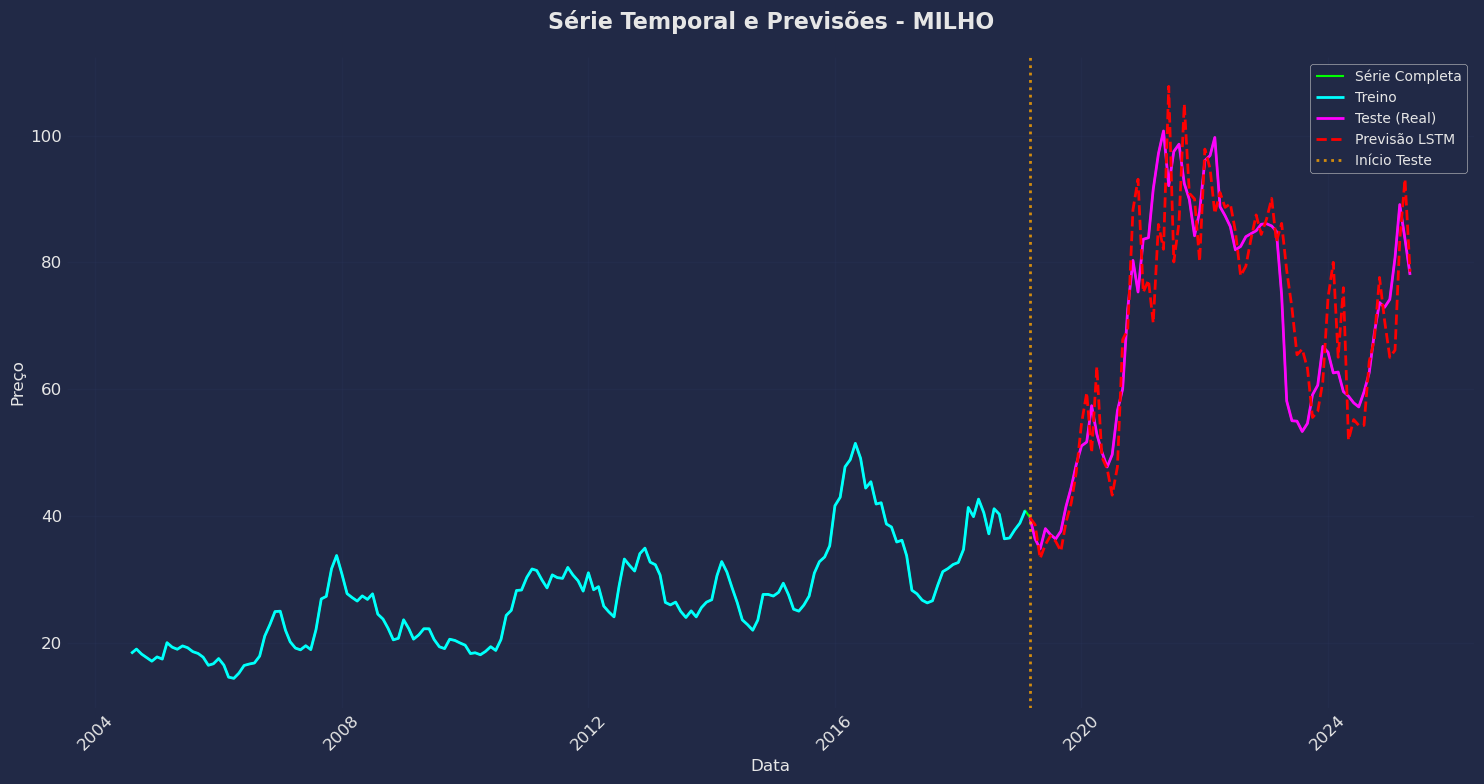

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Gráfico exibido para: MILHO
--------------------------------------------------

=== Rodando Cross Validation para SOJA_PARANA (Teste=101) ===



  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 50.4 K | train
4 | mlp_decoder  | MLP           | 2.1 K  | train
-------------------------------------------------------
52.5 K    Trainable params
0         Non-trainable params
52.5 K    Total params
0.210     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

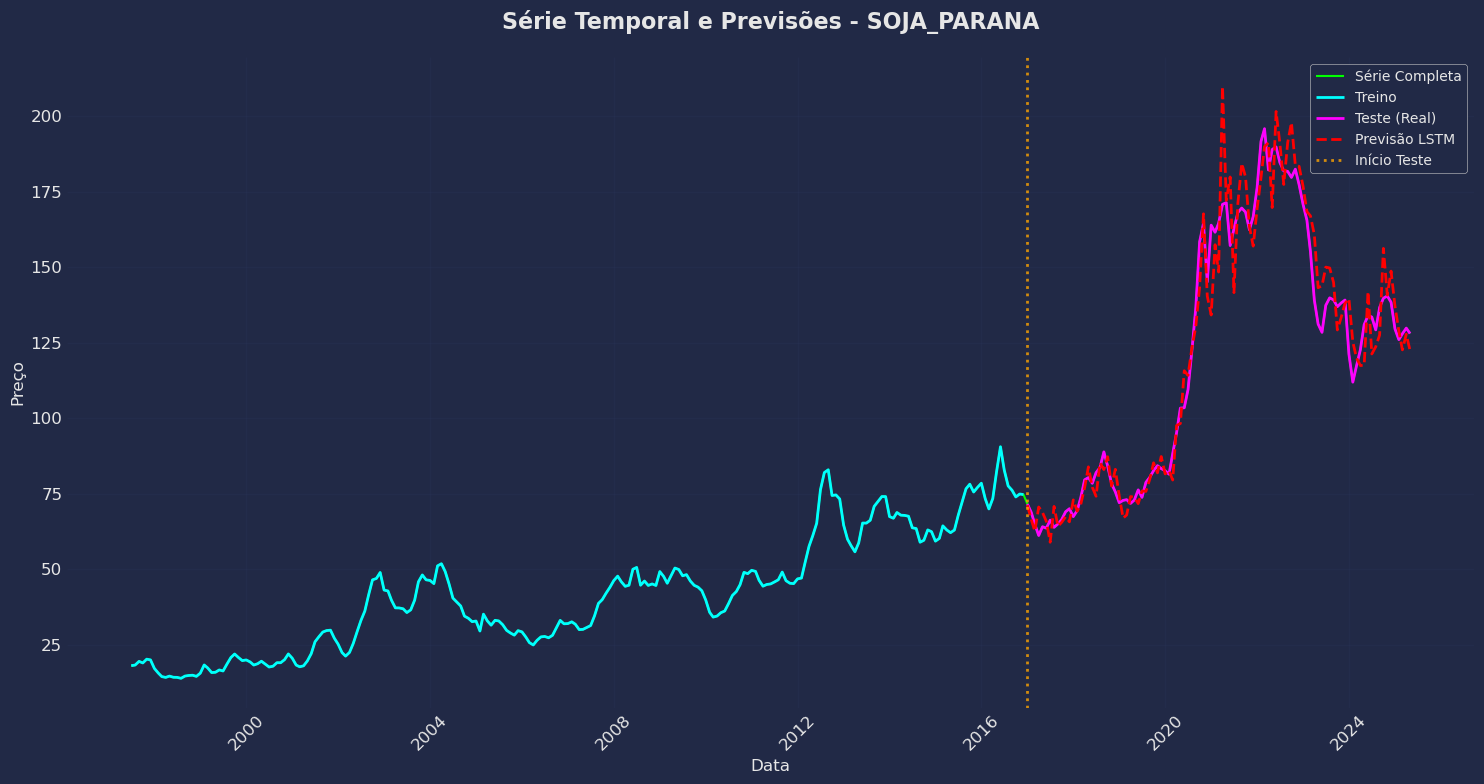

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Gráfico exibido para: SOJA_PARANA
--------------------------------------------------

=== Rodando Cross Validation para SOJA_PARANAGUA (Teste=70) ===



  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 50.4 K | train
4 | mlp_decoder  | MLP           | 2.1 K  | train
-------------------------------------------------------
52.5 K    Trainable params
0         Non-trainable params
52.5 K    Total params
0.210     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

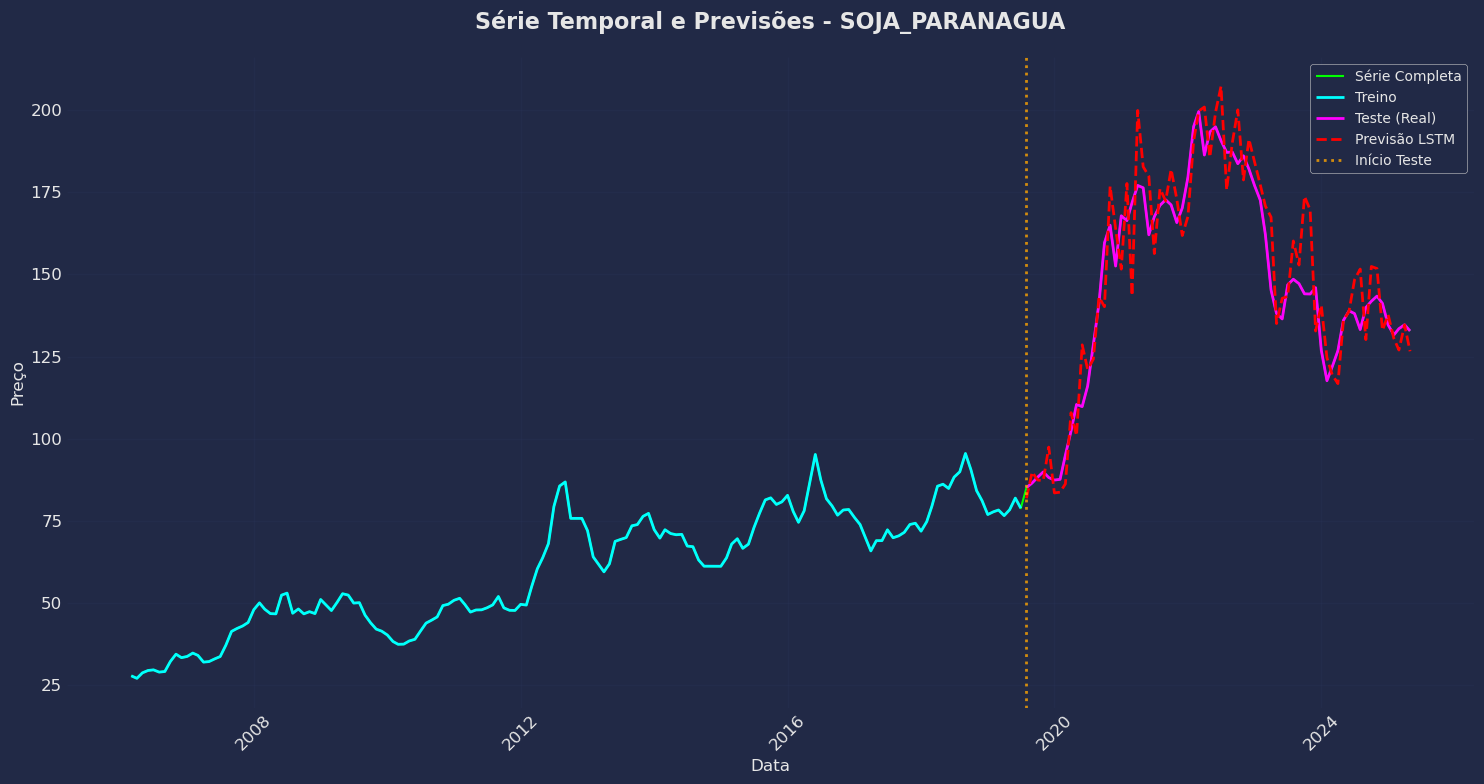

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Gráfico exibido para: SOJA_PARANAGUA
--------------------------------------------------

=== Rodando Cross Validation para TRIGO_PARANA (Teste=77) ===



  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 50.4 K | train
4 | mlp_decoder  | MLP           | 2.1 K  | train
-------------------------------------------------------
52.5 K    Trainable params
0         Non-trainable params
52.5 K    Total params
0.210     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

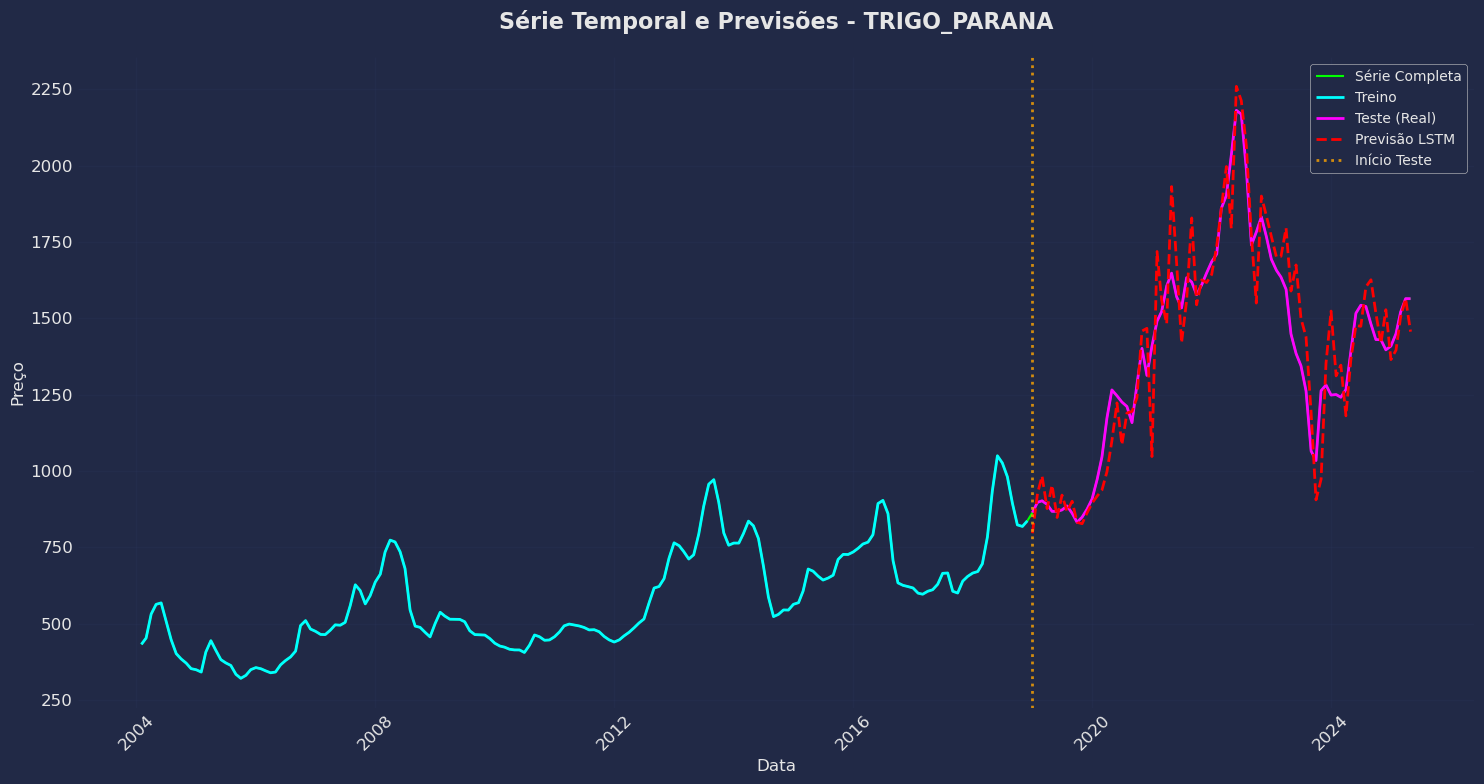

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Gráfico exibido para: TRIGO_PARANA
--------------------------------------------------

=== Rodando Cross Validation para TRIGO_RS (Teste=77) ===



  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 50.4 K | train
4 | mlp_decoder  | MLP           | 2.1 K  | train
-------------------------------------------------------
52.5 K    Trainable params
0         Non-trainable params
52.5 K    Total params
0.210     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

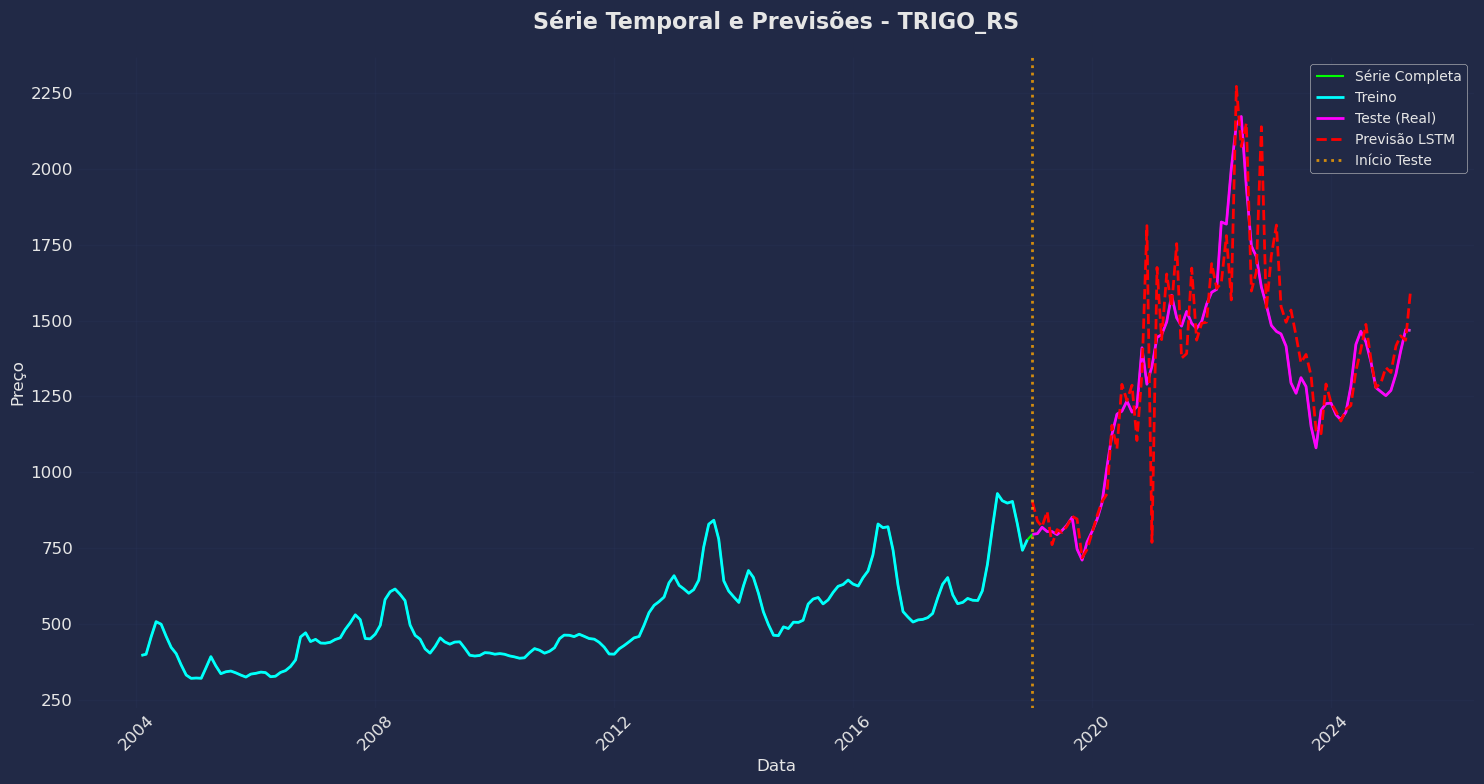

Gráfico exibido para: TRIGO_RS
--------------------------------------------------


In [8]:
series_test_sizes = {
    "ACUCAR_SANTOS": 20,
    "ACUCAR_SP": 80,
    "ALGODAO": 105,
    "ARROZ": 72,
    "CAFE_ARABICA": 104,
    "CAFE_ROBUSTA": 87,
    "MILHO": 75,
    "SOJA_PARANA": 101,
    "SOJA_PARANAGUA": 70,
    "TRIGO_PARANA": 77,
    "TRIGO_RS": 77
}

results = {}

for uid, test_size in series_test_sizes.items():
    print(f"\n=== Rodando Cross Validation para {uid} (Teste={test_size}) ===")
    
    df = df_brl[df_brl['unique_id'] == uid]
    
    cv_df = fcst.cross_validation(
        df=df,
        step_size=1,
        n_windows=test_size,
        # fitted=True,
        refit=False
    )
    
    plot_single_series_and_forecasts(df, cv_df, test_size)
    
    results[uid] = {
        "cv_df": cv_df
    }